Author: Simon Fei - Triton NeuroTech at UCSD
<br>
Acknowledgement: Wearable Sensing, Brainda Project

## Illustration
<img src="../images/flashing.gif" width="600" height="600">
<img src="../images/illustration.png" width="600" height="600">

[Full 32-class SSVEP video demo](https://youtu.be/-5eUUtTdpno)

## Import required packages

In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# sns.set(rc={'axes.facecolor':'black'})
sns.set(rc={'axes.facecolor':'white'})
from matplotlib.colors import LogNorm

# Data wrangling & filtering
import pandas as pd
import numpy as np
import mne
from scipy.fftpack import fft

# Modeling
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import clone
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import normalize
from brainda.algorithms.utils.model_selection import (
    set_random_seeds, 
    generate_loo_indices, match_loo_indices)
from brainda.algorithms.decomposition import (
    FBTRCA, FBTDCA, FBSCCA, FBECCA, FBDSP,
    generate_filterbank, generate_cca_references)

# Utils
import os
from tqdm import tqdm
import sys
from collections import OrderedDict

/Users/aidantruel/Desktop/tnt_workshop/Triton-NeuroTech-Project-Workshop/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experimental constants

The DSI-24 headset follows the 10-20 EEG electrode placements: <br>
<img src="../images/10-20_system_for_EEG.png" width="600" height="600">

Question: Which electrodes are most responsible for the model performance? Are all the electrodes necessary? Can model performance be improved using a subset of electrodes?

In [2]:
# -- Fixed Constants
sub_dirs = ['run1/','run2/','run3/','run4/','run5/','run6/','run7/','run8/','run9/']  # each folder is a single independent run with 2-4 trials
CHANNELS = [' P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Pz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'T6', 'T4']
n_classes = 32  # number of classes, 8 freq, 4 phase, total of 8 * 4 = 32 targets
n_channels = 19  # number of useful recording channels, 24 - 5 = 19 as'TRG',' X1',' X2',' X3',' A2' are not that useful
srate = 300 # sampling rate of the headset (DSI-24)
TIMEPT_TO_MS_RATIO = 1000 / srate  # timepoint * timept_to_ms_ratio = ms
assert len(CHANNELS) == n_channels

# -- Modifiable constants
duration = 1.5  # duration of a trial in seconds
onset_delay = 42 # number of samples to discard to account for visual delay

## Data wrangling

In [3]:
def load_eeg(eeg, meta, classes, stim_duration=5, sfreq=300, filter=True, drop_chan=['time',' TRG',' X1',' X2',' X3',' A2']):
    """
    Turn 1 run of pandas-format eeg into numpy-format eeg
    eeg : pandas-format eeg data object
    meta : pandas-format meta data object
    classes : the classes contained in the mata data

    returns eeg : numpy-format eeg data object in the dimension (num_trial, num_classes, num_channels, num_samples)
    """
    
    trials = meta[1:,:2]
    times = []
    duration_samples = int(stim_duration*sfreq)
    for index, row in eeg.loc[eeg[' TRG']==16.0].iterrows():
        if index > 0 and eeg.iloc[index-1][' TRG'] == 0 and (not eeg.iloc[index:index+duration_samples][' TRG'].isin([18.0]).any()):
            times.append(row['time'])
    times = np.array(times)
    
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=drop_chan).to_numpy()[:duration_samples].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

def load_dataset(path="../data/",
                sub_dirs=['run1/','run2/','run3/','run4/','run5/','run6/','run7/','run8/','run9/','run10/'],
                drop_chan=['time',' TRG',' X1',' X2',' X3',' A2'],
                duration=1.5,
                n_trials=2,
                n_classes=32,
                sfreq=300):
    """
    Load an eeg dataset by loading each individual runs and stacking them into a single numpy-format eeg object
    path : the directory of the dataset
    sub_dirs : the sub-folders each containing 1 block of the experiment
    n_trials : number of trials per class contained in 1 block
    drop_chans : channels to discard (could be non-eeg)

    returns eeg : numpy-format eeg data object in the dimension (num_trial, num_classes, num_channels, num_samples)
            target_by_trial: list with shape (num_trial, num_classes, 2), the first item of the last dimension encodes frequency, while the second item of the last dimension encodes phase in units of pi
            target_table: dictionary with keys being (freq, phase), and value being a target from 0, 1, ..., 32, i.e. (8.0, 0.5): 3 is our target 3, which corresponds to 8 Hz with 0.5 pi phase
    """

    n_channels = 25 - len(drop_chan)
    # load experimental dataset
    eeg_whole = np.zeros((n_trials*len(sub_dirs),n_classes,n_channels,int(duration*sfreq)))
    target_tab = {}
    for i_dir,sub_dir in enumerate(tqdm(sub_dirs, desc='Loading Data...', leave=False, file=sys.stdout)):
        data_path = path + sub_dir
        eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
        meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
        trials = meta[1:,:2]
        classes = np.unique(trials, axis=0)
        more_targets = {tuple(target):index for index,target in enumerate(classes)}
        target_tab.update(more_targets)
        eeg = load_eeg(eeg, meta, classes, stim_duration=duration,filter=False,drop_chan=drop_chan)
        eeg_whole[i_dir*n_trials:(i_dir+1)*n_trials,:,:,:] = eeg
    eeg = eeg_whole
    target_by_trial = [list(target_tab.keys())] * n_trials*len(sub_dirs)
    return eeg, target_by_trial, target_tab

In [4]:
eeg, target_by_trial, target_tab = load_dataset()
print('EEG data shape: ', eeg.shape)
print('Target by trial shape: ', np.array(target_by_trial).shape) 
print('Target table: ', target_tab)
print('Target number for 8 Hz with 0.5 pi phase: ', target_tab[(8, 0.5)])

EEG data shape:  (20, 32, 19, 450)                                              
Target by trial shape:  (20, 32, 2)
Target table:  {(8.0, 0.0): 0, (8.0, 0.5): 1, (8.0, 1.0): 2, (8.0, 1.5): 3, (9.0, 0.0): 4, (9.0, 0.5): 5, (9.0, 1.0): 6, (9.0, 1.5): 7, (10.0, 0.0): 8, (10.0, 0.5): 9, (10.0, 1.0): 10, (10.0, 1.5): 11, (11.0, 0.0): 12, (11.0, 0.5): 13, (11.0, 1.0): 14, (11.0, 1.5): 15, (12.0, 0.0): 16, (12.0, 0.5): 17, (12.0, 1.0): 18, (12.0, 1.5): 19, (13.0, 0.0): 20, (13.0, 0.5): 21, (13.0, 1.0): 22, (13.0, 1.5): 23, (14.0, 0.0): 24, (14.0, 0.5): 25, (14.0, 1.0): 26, (14.0, 1.5): 27, (15.0, 0.0): 28, (15.0, 0.5): 29, (15.0, 1.0): 30, (15.0, 1.5): 31}
Target number for 8 Hz with 0.5 pi phase:  1


## Visualize the data

### Time domain visualization

Text(0.5, 0, 'Time (ms)')

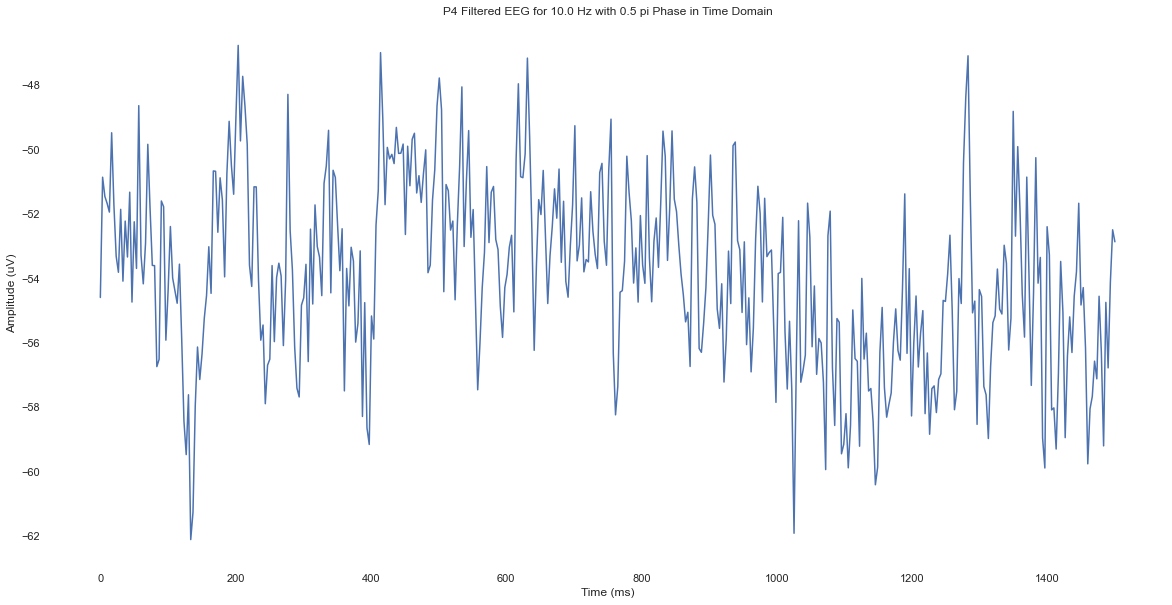

In [5]:
channel = 'P4'
assert channel in CHANNELS, f'{channel} not found in {CHANNELS}'
freq = 10.0
phase = 0.5  # unit: pi

eeg_trial_avg = eeg.mean(axis=0)  # Average across trials
num_timept = eeg_trial_avg.shape[-1]

plt.figure(figsize=(20, 10))
ax = sns.lineplot(x=np.linspace(0, num_timept * TIMEPT_TO_MS_RATIO, num_timept), y=eeg_trial_avg[target_tab[(freq, phase)], CHANNELS.index(channel)])
plt.ylabel('Amplitude (uV)')
plt.title(f'{channel} Filtered EEG for {freq} Hz with {phase} pi Phase in Time Domain')
plt.xlabel('Time (ms)')

### Frequency domain visualization

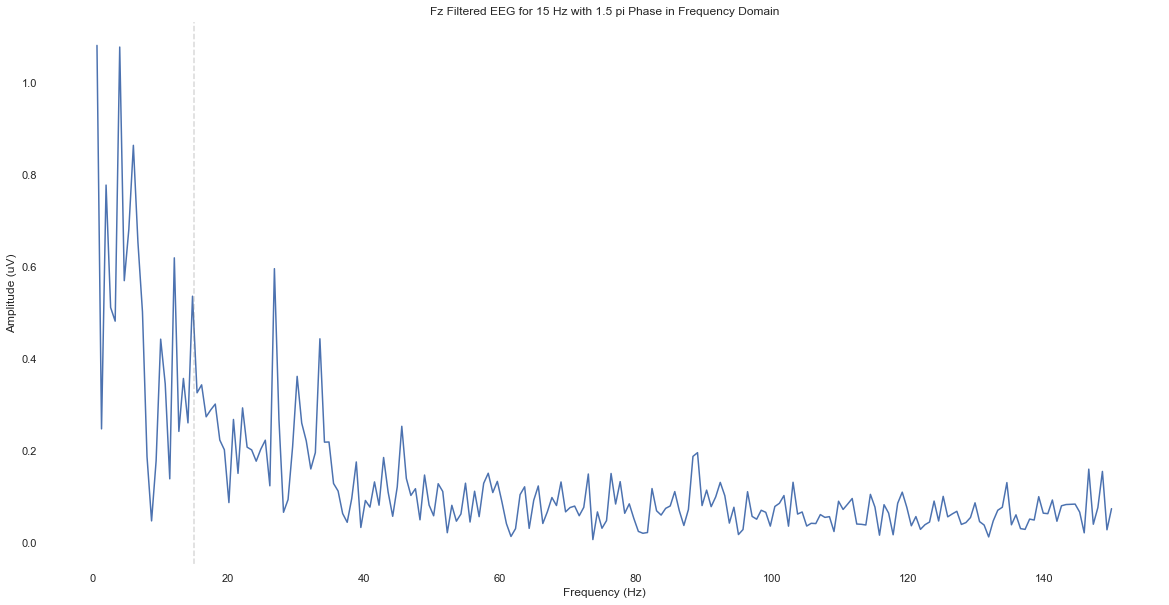

In [6]:
channel = 'Fz'
assert channel in CHANNELS, f'{channel} not found in {CHANNELS}'
freq = 15
phase = 1.5  # unit: pi

eeg_trial_avg = eeg.mean(axis=0)  # Average across trials
num_timept = eeg_trial_avg.shape[-1]
freqs = np.linspace(0.0, srate / 2, int(num_timept / 2))
freq_avg_potential = fft(eeg_trial_avg)[:, :, 0: int(num_timept / 2)]
freq_avg_potential = 2 / num_timept * np.abs(freq_avg_potential)

plt.figure(figsize=(20, 10))
starting_idx = 1 # skipping first index as value for 0 Hz is extremely high for some reasons
amplitude = freq_avg_potential[target_tab[(freq, phase)], CHANNELS.index(channel), :]
ax = sns.lineplot(x=freqs[starting_idx:], y=amplitude[starting_idx:])
ax.axvline(x=freq, linestyle='--', color='gray', alpha=0.3)
ax.set_title(f'{channel} Filtered EEG for {freq} Hz with {phase} pi Phase in Frequency Domain')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (uV)');

The peaks at the corresponding frequency is not quite obvious here. This can be due to the stimulus duration being too short

## Apply Modeling Algorithm

In [48]:
# changed from duration=1.5, onset_delay=42
def run_fbtrca(eeg, target_by_trial, target_tab, duration, onset_delay, srate=300):
    """
    Assess the LOO(Leave-One-Out) accuracy of FBTRCA(Filter-Bank Task-Related Component Analysis) from the Brainda Package
    eeg : numpy-format eeg data in the dimension (num_trial, num_classes, num_channels, num_samples)
    target_by_trial : the corresponding class label of each trial
    target_tab : a table matching class label to its corresponding frequency-phase pair

    returns confusion_matrix, : the confusion matrix of all LOO runs
            loo_accuracy, : the mean of all LOO accuracies
            last_model : the model of the last LOO run
    """

    eeg = np.copy(eeg)
    np.random.seed(64)
    np.random.shuffle(eeg)
    n_trials = eeg.shape[0]
    classes = range(32)
    n_classes = len(classes)
    prob_matrix=np.zeros((n_classes,n_classes))
    y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
    eeg_temp = eeg[:n_trials,classes,:,onset_delay:]
    X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

    n_bands = 3
    wp = [[8*i, 90] for i in range(1, n_bands+1)]
    ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
    filterbank = generate_filterbank(
        wp, ws, srate, order=4, rp=1)
    filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
    set_random_seeds(64)
    l = 5
    models = OrderedDict([
        ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ])
    events = []
    for j_class in classes:
        events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
    events = np.array(events)
    subjects = ['1'] * (n_classes*n_trials)
    meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
    set_random_seeds(42)
    loo_indices = generate_loo_indices(meta)

    for model_name in models:
        if model_name == 'fbtdca':
            filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
        else:
            filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
        
        filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

        n_loo = len(loo_indices['1'][events[0]])
        loo_accs = []
        testYs = []
        pred_labelss = []
        for k in range(n_loo):
            train_ind, validate_ind, test_ind = match_loo_indices(
                k, meta, loo_indices)
            train_ind = np.concatenate([train_ind, validate_ind])

            trainX, trainY = filterX[train_ind], filterY[train_ind]
            testX, testY = filterX[test_ind], filterY[test_ind]

            model = clone(models[model_name]).fit(
                trainX, trainY
            )
            pred_labels = model.predict(testX)
            loo_accs.append(
                balanced_accuracy_score(testY, pred_labels))
            pred_labelss.extend(pred_labels)
            testYs.extend(testY)
        #print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))
    # return confusion_matrix(testYs, pred_labelss, normalize='true'), accuracy_score(testYs, pred_labelss), model
    return accuracy_score(testYs, pred_labelss)

def cm_graph(cm, acc):
    """
    Plot confusion matrix and include an accuracy score on the title
    cm : the confusion matrix in the dimension (32,32)
    acc : the accuracy score
    """

    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(cm, cmap='Blues_r', norm=LogNorm())
    ax.set_title('loo acc: '+str(acc));
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    ax.xaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = -90);
    ax.yaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = 0);
    ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
    ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())
    plt.show()

Question: can we play around different values for onset_delay to try to improve the model performance? Or can we algorithmically determine the best onset_delay value?

*Suggested Reading* <br>
[High-speed spelling with a noninvasive brain–computer interface](https://www.pnas.org/doi/10.1073/pnas.1508080112): Take a look at figure 1c <br>

In [ ]:
#changed from duration=duration, onset_delay=onset_delay
confusion_matrix, mean_loo_accuracy, last_model = run_fbtrca(eeg, target_by_trial, target_tab, 1.5, 42)

Question: Currently we achieve 90% accuracy with 1.5 seconds of data. Can we improve this performance by performing hyperparamer tuninig? (i.e. play around with other parameters in FBTRCA and figure out if performance is better)

*Suggested Reading* <br> Feel free to look into the [TRCA paper](https://arxiv.org/pdf/2201.12153.pdf): more detailed explaination than Brainda

In [ ]:
cm_graph(confusion_matrix, mean_loo_accuracy)

Question: What other models can we try? Is there any other salient models we should try from Meegkit or Brainda? <br>

*Suggested Reading* <br>
Brainda: https://github.com/TBC-TJU/brainda.git <br>
Meegkit: https://github.com/nbara/python-meegkit  <br>




Question: Is 1.5 seconds too long? Can we still retain performance using less amount of seconds? We know that performance supposedly decreases as duration decreases. What's a good tradeoff between time and accuracy?

*Suggested Reading* <br>
[High-speed spelling with a noninvasive brain–computer interface](https://www.pnas.org/doi/10.1073/pnas.1508080112): Take a look at the Information Transfer Rate Section <br>




In [72]:
od_min = 40
od_max = 44
od_step = 1
dur_min = 1.35
dur_max = 1.47
dur_step = 0.05
od_list = list(np.arange(od_min, od_max, od_step))
dur_list = list(np.arange(dur_min, dur_max, dur_step))
results_store = np.empty([len(dur_list), len(od_list)], dtype=float)

In [73]:
print('Duration', 'Delay', 'Accuracy', sep='\t')
for od_count, od in enumerate(od_list):
    for dur_count, dur in enumerate(dur_list):
        mean_loo_accuracy = run_fbtrca(eeg, target_by_trial, target_tab, dur, od)
        results_store[dur_count][od_count] = mean_loo_accuracy
        dur_string = "{:.2f}".format(dur)
        acc_string = "{:.4f}".format(mean_loo_accuracy)
        print(dur_string, od, acc_string, sep='\t')

Duration	Delay	Accuracy
1.35	40	0.8953
1.40	40	0.8953
1.45	40	0.8953
1.35	41	0.9000
1.40	41	0.9016
1.45	41	0.9016
1.35	42	0.8984
1.40	42	0.9000
1.45	42	0.9000
1.35	43	0.8906
1.40	43	0.8906
1.45	43	0.8906


## Visualize Model Features

Question: How do we visualze what the models are doing? Can we explain why certain models are more favorable than the others with the data we have?


In [ ]:
# the templates are trial average of the time series
templates = np.copy(last_model.estimators_[0].templates_)
print(templates.shape)
plt.figure(figsize=(20,2))
plt.plot(templates[28,14]);
plt.plot(templates[30,14]);

In [ ]:
# Non-ensamble filtering of the templates
templates = np.copy(last_model.estimators_[0].templates_)
n_comp = last_model.estimators_[0].n_components

# This is the non-ensable way of applying the learned spatial filter to the templates
Us = last_model.estimators_[0].Us_ # copy over the filter
for i_template, template in enumerate(templates):
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)

print(templates.shape)
plt.figure(figsize=(20,2))
plt.plot(templates[28,14]);
plt.plot(templates[30,14]);

In [ ]:
# Ensamble filtering of the templates
templates = np.copy(last_model.estimators_[0].templates_) # copy over the templates
U = np.copy(last_model.estimators_[0].Us_)[:, :, :last_model.n_components] # copy over the filter
U = np.concatenate(U, axis=-1)
filtered_templates=np.zeros((templates.shape[0],templates.shape[0]*templates.shape[2]))
for i_template, template in enumerate(templates):
    filtered_templates[i_template] = np.reshape((U.T@template),(-1))
    
print(filtered_templates.shape)
plt.figure(figsize=(20,2))
t_length=int(filtered_templates.shape[1]/filtered_templates.shape[0])
plt.plot(filtered_templates[28,:t_length]);
plt.plot(filtered_templates[30,:t_length]);